### Preprocessing

In [1]:
import pandas as pd

In [2]:
df = pd.read_table('data/pdbbind/index/INDEX_general_PL_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df = df.rename(columns={'#': 'name','release': 'affinity'})
df_refined = pd.read_table('data/pdbbind/index/INDEX_refined_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df_refined = df_refined.rename(columns={'#': 'name','release': 'affinity'})
df = pd.concat([df,df_refined])

In [3]:
quantities = ['ki','kd','ka','k1/2','kb','ic50','ec50']

In [4]:
from pint import UnitRegistry
ureg = UnitRegistry()

def to_uM(affinity):
    val = ureg(affinity)
    try:
        return val.m_as(ureg.uM)
    except Exception:
        pass
    
    try:
        return 1/val.m_as(1/ureg.uM)
    except Exception:
        pass

In [5]:
df['affinity_uM'] = df['affinity'].str.split('[=\~><]').str[1].apply(to_uM)
df['affinity_quantity'] = df['affinity'].str.split('[=\~><]').str[0]

<AxesSubplot:>

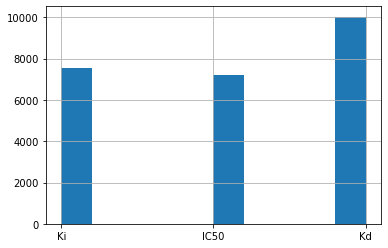

In [6]:
df['affinity_quantity'].hist()

In [7]:
df_filter = df[df['affinity_quantity'].str.lower().isin(quantities)]
df_filter = df_filter.dropna()

In [8]:
cutoffs = [5,8,11]

In [9]:
dfs_complex = {c: pd.read_parquet('data/pdbbind_complex_{}.parquet'.format(c)) for c in cutoffs}

In [10]:
list(dfs_complex.values())[0].head()

name                                                seq  \
0  10gs  PYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKASC...   
1  184l  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...   
2  186l  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...   
3  187l  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...   
4  188l  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...   

                                              smiles  
0  [NH3+]C(CCC(=O)NC(CSCc1ccccc1)C(=O)NC(C(=O)O)c...  
1                                     CC(C)Cc1ccccc1  
2                                       CCCCc1ccccc1  
3                                       Cc1ccc(C)cc1  
4                                         Cc1ccccc1C

In [11]:
import dask.array as da
import dask.dataframe as dd
from dask.bag import from_delayed
from dask import delayed
import pyarrow as pa
import pyarrow.parquet as pq

In [12]:
contacts_dask = [da.from_npy_stack('data/pdbbind_contacts_{}'.format(c)) for c in cutoffs]
contacts_dask = [c.reshape(-1,c.shape[-2]*c.shape[-1]) for c in contacts_dask]

In [13]:
contacts_dask[0].blocks[1]

dask.array<blocks, shape=(438, 1043460), dtype=float32, chunksize=(438, 1043460), chunktype=numpy.ndarray>

In [14]:
[len(c) for c in contacts_dask]

[16206, 16181, 16172]

In [15]:
contacts_dask[0].shape[0]

16206

In [16]:
dfs_complex[5].iloc[16205]

name                                                   9lpr
seq       ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...
smiles    CC(C)CC(NC(=O)C1CCCN1C(=O)C(C)NC(=O)C(C)[NH3+]...
Name: 16205, dtype: object

In [17]:
import numpy as np
all_partitions = []
for c, cutoff in zip(contacts_dask,cutoffs):
    def chunk_to_sparse(rcut, chunk, idx_chunk):
        res = dfs_complex[rcut].iloc[idx_chunk][['name']].copy()
        # pad to account for [CLS] and [SEP]
        res['contacts_{}A'.format(rcut)] = [np.where(np.pad(a,pad_width=(1,1)))[0] for a in chunk]
        return res

    partitions = [delayed(chunk_to_sparse)(cutoff,b,k)
                  for b,k in zip(c.blocks, da.arange(c.shape[0],chunks=c.chunks[0:1]).blocks)
                 ]
    all_partitions.append(partitions)

In [18]:
all_partitions[0][0].compute().head()

name                                        contacts_5A
0  10gs  [1021, 1022, 1070, 1073, 1075, 3071, 3072, 307...
1  184l  [39279, 39280, 39281, 39282, 42332, 42334, 423...
2  186l  [39277, 39278, 39279, 42332, 42333, 42334, 423...
3  187l  [39271, 39272, 39281, 42331, 42332, 42334, 423...
4  188l  [39271, 39272, 39274, 39275, 42331, 42332, 423...

In [19]:
ddfs = [dd.from_delayed(p) for p in all_partitions]

In [20]:
ddf_all = None
for d in ddfs:
    if ddf_all is not None:
        ddf_all = ddf_all.merge(d, on='name')
    else:
        ddf_all = d
ddf_all = ddf_all.merge(df_filter,on='name')
ddf_all = ddf_all.merge(list(dfs_complex.values())[0],on='name')

In [21]:
%%time
df_all_contacts = ddf_all.compute()

CPU times: user 6min 9s, sys: 12min 7s, total: 18min 17s
Wall time: 7min 36s


In [22]:
df_all_contacts['neg_log10_affinity_M'] = 6-np.log10(df_all_contacts['affinity_uM'])

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_all_contacts['affinity'] = scaler.fit_transform(df_all_contacts['neg_log10_affinity_M'].values.reshape(-1,1))
scaler.mean_, scaler.var_

(array([6.35008182]), array([3.56554195]))

In [24]:
# save to parquet
df_all_contacts.drop(columns=['name','affinity_quantity']).astype({'affinity': 'float32','neg_log10_affinity_M': 'float32'}).to_parquet('data/pdbbind_with_contacts.parquet',index=False)